

# **Synchronization in Complex Networks and Applications**


---





Victor Hugo F. Francheto

University of São Paulo, SP

victor.francheto@usp.br



Bruno B. Pereira

University of São Paulo, SP

bruno.pereira@usp.br


---



**Tema escolhido:**

### **5 - Como a sincronização é inPuenciada pela topologia da rede?**

Ver: https://github.com/fabridamicelli/kuramoto

Use o artigo:
Synchronization in complex networks
https://www.sciencedirect.com/science/ar;cle/pii/S0370157308003384

Gerar redes usando diferentes modelos e verificar como a sincronização muda de acordo com o
modelo. Pode ser gerado um gráfico do parâmetro de ordem (r) em função do acomplamento
lambda.

Analisar como a estrutura de comunidades afeta a sincronização, mudando o parâmetro mu no
modelo de LFR que gera redes modulares.

---

Iniciamos importando os pacotes basicos para o estudo.

In [50]:
from pylab import *
import numpy as np
from numpy import linalg as LA
from scipy.integrate import *
import matplotlib.pyplot as plt
from scipy.special import zeta
import networkx as nx
import community.community_louvain as community_louvain
import random

Para estudar a sincronização em diferentes topologias, utilizaremos o modelo de Kuramoto.

In [51]:
# First-order Kuramoto model
def F(Y,t, G, W, lbd):
    #global W, N, lbd, G
    N = len(G.nodes())
    F = zeros((N),float)
    S = zeros((N),float)
    dg = G.degree()
    for i in range(0,N):
        for j in G.neighbors(i):
            S[i] = S[i] + sin(Y[j]-Y[i]) #
    ld = lbd
    F = W + ld*S #traditional Kuramoto
    return F

Aqui estamos definindo alguns paramentros das redes que analizaremos a sincronização.

In [52]:
#>>Parametros de Rede<<#

#Número de nós
N = 150

# Grau médio
av_degree = 6

# Probabilidade de conexão para Modelos Erdős–Rényi
p = float(av_degree)/float(N)

# Número de nós incluídos a cada passo de tempo no modelo Barabasi Albert e Waxman
m = int(av_degree/2)

# Número de vizinhos no modelo Small Words
kappa = av_degree

#>>Paremetros de redes com comunidades<<#

# Definir tamanhos das partições (comunidades)
partition_sizes = [30, 30, 20]

# Probabilidade de aresta dentro da mesma comunidade
p_in = 0.5

# Probabilidade de aresta entre comunidades diferentes
p_out = 0.02
seed = 42


#>>Paremetros de redes com comunidades LFV<<#
tau1 = 2
tau2 = 2
mu = 0.1
minc = 20
maxc = 200

#>>Parametros Barabasi não linear<<#
n_ = 100  # Número total de nós
m0_ = 5   # Número inicial de nós
m_ = 3    # Número de arestas que cada novo nó criará
alpha_ = 1.5  # Parâmetro de não linearidade



In [53]:

def rede_com_comunidades(partition_sizes,p_in,p_out,seed):

  # Definir tamanhos das partições (comunidades)
  partition_sizes = partition_sizes

  # Definir probabilidades de conexão
  p_in = p_in  # Probabilidade de aresta dentro da mesma comunidade
  p_out = p_out # Probabilidade de aresta entre comunidades diferentes

  # Gerar o grafo particionado aleatório
  G = nx.random_partition_graph(partition_sizes, p_in, p_out, seed=seed)
  return G




In [54]:
def rede_com_comunidades_LFR(N, tau1, tau2, mu, k, minc, maxc):
  N = N
  tau1 = tau1
  tau2 = tau2
  mu = mu
  k = k
  minc = minc
  maxc = maxc
  G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k,
                          max_degree = k, min_community=minc, max_community = maxc, seed = 10)
  return G

In [55]:
def rede_eros_renie(N,p,seed):
  N = N
  p = p
  seed = seed
  G = nx.gnp_random_graph(N, p, seed=seed, directed=False)
  return G

In [56]:
def rede_small_word(N, k, p, seed):
  N = N
  k = k
  p = p
  seed = seed
  k = int(k)
  G = nx.watts_strogatz_graph(N, k, p, seed=seed)
  return G


In [57]:
def rede_barabasi_albert(N,m):
   m = m
   G = nx.barabasi_albert_graph(N, m)
   return G

In [58]:
def nonlinear_barabasi_albert_graph(n, m, alpha, seed=None):

    if seed is not None:
        np.random.seed(seed) 
    G = nx.complete_graph(m)

    target_nodes = list(range(m))
    repeated_nodes = []

    for source in range(m, n):
        probs = np.array([G.degree(node)**alpha for node in target_nodes], dtype=np.float64)
        norm_probs = probs / probs.sum()
        new_edges = np.random.choice(target_nodes, size=m, replace=False, p=norm_probs)
        G.add_edges_from(zip([source] * m, new_edges))
        target_nodes.append(source)
        repeated_nodes.extend(new_edges)
        repeated_nodes.extend([source] * m)

    return G



In [59]:
def rede_waxman(N,seed):
   seed = seed
   G = nx.waxman_graph(N, seed=seed)
   return G

In [60]:
def imagem_rede(G):
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  G = nx.convert_node_labels_to_integers(G, first_label=0)
  pos = nx.spring_layout(G)
  return nx.draw(G, pos, node_color="c", node_size=10, with_labels=False)

In [61]:

def calculando_sincronizacao(G):
  G = G.to_undirected() # Remevendo direção da Rede
  G = nx.convert_node_labels_to_integers(G, first_label=0) # Convertendo os Labels em inteiros
  N = len(G) # Número de Nós

  vk = dict(G.degree()) # Grau
  vk = list(vk.values()) # ??
  av_k = mean(vk) # Grau Médio

  A = nx.adjacency_matrix(G) #Criando matriz de adjacencia
  A = A.todense() #ajustando a matrix
  eig, vectors = LA.eig(A) # Calculando auto valores
  lambda_max = eig.max() # Obtendo o maior auto valor

  #>>Initial phases<<#
  w0 = np.pi
  y0 = np.random.normal(0, w0, size = N)

  # Frequência Natural
  W = np.random.uniform(-w0, w0, size = N)

  # Acoplamento Crítico
  hist, bin_edges = np.histogram(W, density=True)
  g0 = max(hist)
  lambda_c = 2/(np.pi*lambda_max*g0)

  # Tempo de Integração
  t0 = 0.0  # Inicio
  h = 0.02 # Incremento
  Np = 3000 # Numero de interações
  tStop = int(Np*h) # Fim da Integração
  t = linspace(t0,tStop,Np)

  #>>Processo de Sincronização<<#
  vlbd = []  # vetor que armazena a força de acoplamento
  aux = 0
  Ns = 1 # Numero de Simulações
  vlbd = np.arange(0, 10*lambda_c, lambda_c/5) #variation of the coupling strength
  mvr = np.zeros(shape=shape(vlbd))
  for s in arange(0,Ns):
      vr = []  # vector that stores the order parameter
      for lbd in vlbd:
          y = odeint(F, y0, t, (G, W, lbd))
          y = np.array(y)
          y = y[range(len(y)-round(0.9*len(y)),len(y)),:]
          y = y.mean(0)
          psi = mean(y)
          r = abs((1.0/N)*sum(np.exp(1j*y)))
          vr.append(r)
          aux = aux + 1
          #print(aux, ": ", lbd, r)
          y0 = y # adiabatic increase
      mvr = mvr + vr
  mvr = mvr/Ns
  vlbd = array(vlbd, dtype=float)
  if len(mvr) != len(vlbd):
    min_length = min(len(vlbd), len(mvr))
    vlbd = vlbd[:min_length]
    mvr = mvr[:min_length]

  return vlbd,mvr,lambda_c

In [13]:
lambda_c=[]

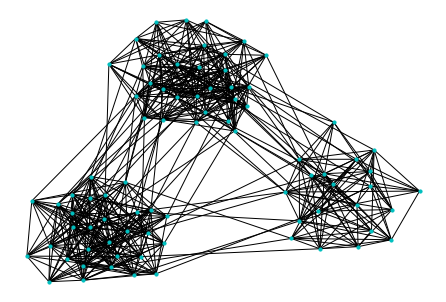

In [196]:
G_1 = nx.Graph()
G_1 = rede_com_comunidades(partition_sizes,p_in,p_out,seed)
vlbd_1,mvr_1,lambda_c_1 = calculando_sincronizacao(G_1)

lambda_c.append([lambda_c_1,'CComu',1])
imagem_rede(G_1)

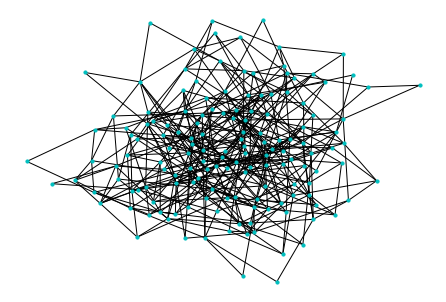

In [26]:
G_2 = nx.Graph()
G_2 = rede_eros_renie(N,p,seed)
vlbd_2,mvr_2,lambda_c_2 = calculando_sincronizacao(G_2)
lambda_c.append([lambda_c_2,'ER',2])
imagem_rede(G_2)

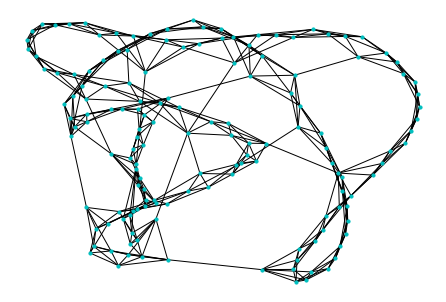

In [27]:
G_3 = nx.Graph()
G_3 = rede_small_word(N, kappa, p, seed)
vlbd_3,mvr_3,lambda_c_3 = calculando_sincronizacao(G_3)
lambda_c.append([lambda_c_3,'SW',3])
imagem_rede(G_3)

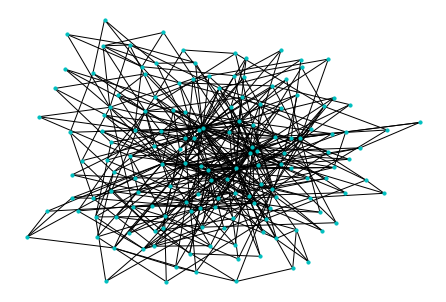

In [29]:
G_4 = nx.Graph()
G_4 = rede_barabasi_albert(N,m)
vlbd_4,mvr_4,lambda_c_4 = calculando_sincronizacao(G_4)
lambda_c.append([lambda_c_4,'BA',4])
imagem_rede(G_4)

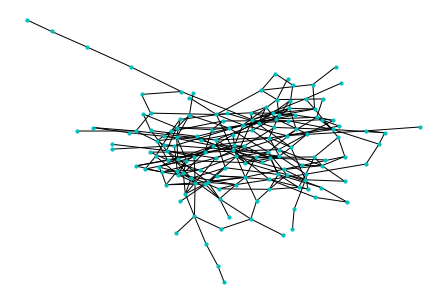

In [33]:
G_5 = nx.Graph()
G_5 = rede_waxman(N,seed)
vlbd_5,mvr_5,lambda_c_5 = calculando_sincronizacao(G_5)
lambda_c.append([lambda_c_5,'WX',5])
imagem_rede(G_5)

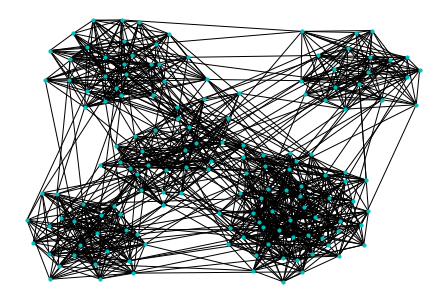

In [70]:
G_6 = nx.Graph()
G_6 = rede_com_comunidades_LFR(N, tau1, tau2, mu, kappa*2, minc, maxc)
vlbd_6,mvr_6,lambda_c_6 = calculando_sincronizacao(G_6)
lambda_c.append([lambda_c_6,'LFR_MU_0.1',0.1])
imagem_rede(G_6)

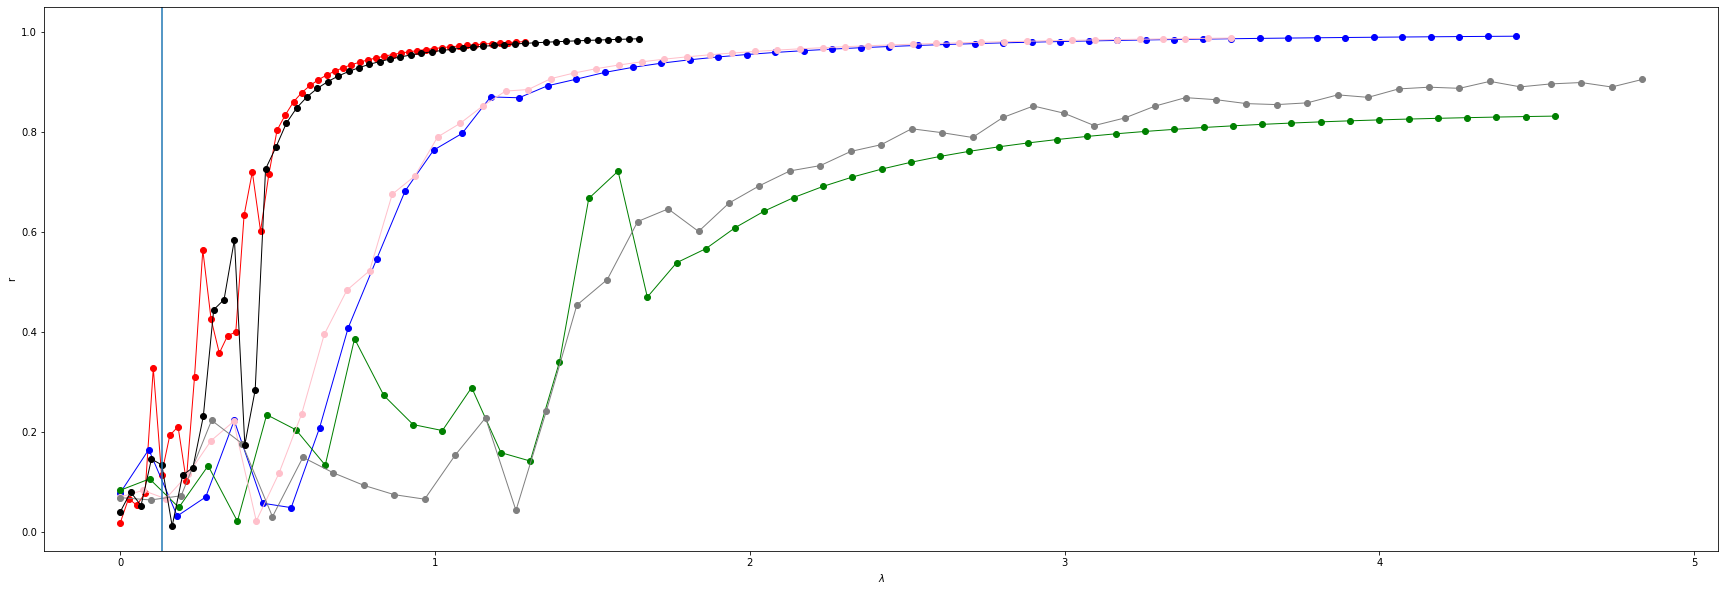

In [35]:
# show the results

plt.figure(figsize=(30,10))
plt.plot(vlbd_1, mvr_1, '-o', color='red', linewidth=1 ) # Com Comunidades
plt.plot(vlbd_2, mvr_2, '-o', color='blue', linewidth=1 ) # ER
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1 ) # SW
plt.plot(vlbd_4, mvr_4, '-o', color='pink', linewidth=1 ) # BA
plt.plot(vlbd_5, mvr_5, '-o', color='gray', linewidth=1 ) # WX
plt.plot(vlbd_6, mvr_6, '-o', color='black', linewidth=1 ) # LFR


plt.axvline(x =lambda_c_1)
xlabel(r"$\lambda$")
ylabel("r")
#plt.legend(True)
plt.plot(True)

In [62]:
lambda_c = []

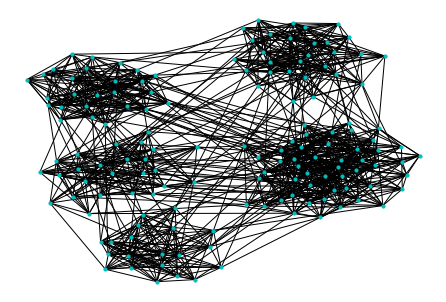

In [63]:
G_8 = nx.Graph()
G_8 = rede_com_comunidades_LFR(N, tau1, tau2, 0.05, kappa*2, minc, maxc)
vlbd_8,mvr_8,lambda_c_8 = calculando_sincronizacao(G_8)
lambda_c.append([lambda_c_8,'LFR_MU_0.05',0.05])
imagem_rede(G_8)

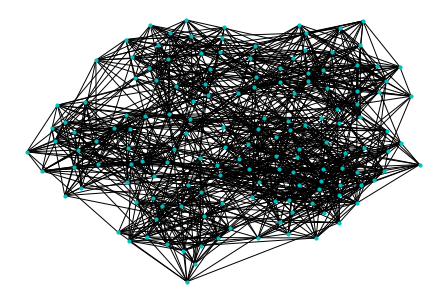

In [64]:
G_9 = nx.Graph()
G_9 = rede_com_comunidades_LFR(N, tau1, tau2, 0.15, kappa*2, minc, maxc)
vlbd_9,mvr_9,lambda_c_9 = calculando_sincronizacao(G_9)
lambda_c.append([lambda_c_9,'LFR_MU_0.15',0.15])
imagem_rede(G_9)

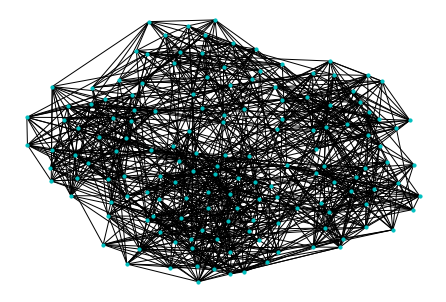

In [65]:
G_10 = nx.Graph()
G_10 = rede_com_comunidades_LFR(N, tau1, tau2, 0.2, kappa*2, minc, maxc)
vlbd_10,mv_10,lambda_c_10 = calculando_sincronizacao(G_10)
lambda_c.append([lambda_c_10,'LFR_MU_0.2',0.2])
imagem_rede(G_10)

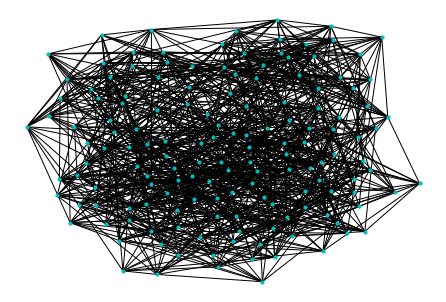

In [66]:
G_11 = nx.Graph()
G_11 = rede_com_comunidades_LFR(N, tau1, tau2, 0.25, kappa*2, minc, maxc)
vlbd_11,mvr_11,lambda_c_11 = calculando_sincronizacao(G_11)
lambda_c.append([lambda_c_11,'LFR_MU_0.25',0.25])
imagem_rede(G_11)

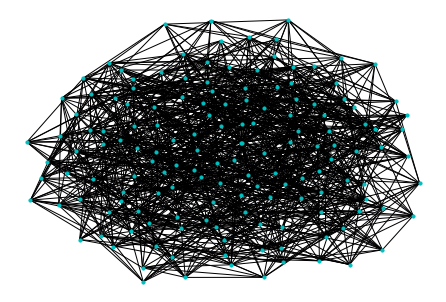

In [67]:
G_12 = nx.Graph()
G_12 = rede_com_comunidades_LFR(N, tau1, tau2, 0.3, kappa*2, minc, maxc)
vlbd_12,mvr_12,lambda_c_12 = calculando_sincronizacao(G_12)
lambda_c.append([lambda_c_12,'LFR_MU_0.3',0.3])
imagem_rede(G_12)

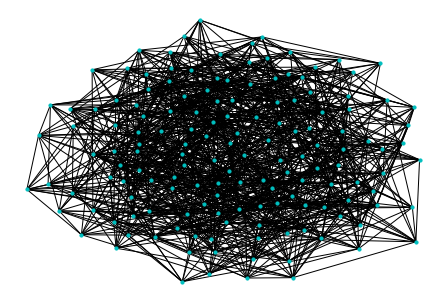

In [68]:
G_13 = nx.Graph()
G_13 = rede_com_comunidades_LFR(N, tau1, tau2, 0.35, kappa*2, minc, maxc)
vlbd_13,mvr_13,lambda_c_13 = calculando_sincronizacao(G_13)
lambda_c.append([lambda_c_13,'LFR_MU_0.35',0.35])
imagem_rede(G_13)

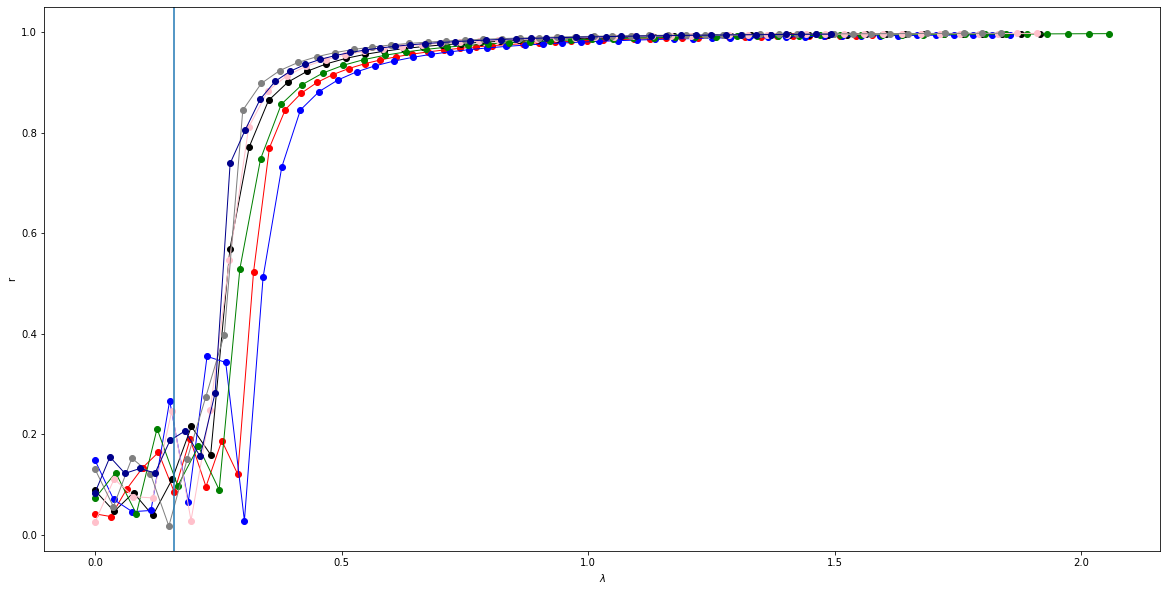

In [71]:
plt.figure(figsize=(20,10))


plt.plot(vlbd_8, mvr_8, '-o', color='red', linewidth=1 ) # LFR MU = 0.05
plt.plot(vlbd_6, mvr_6, '-o', color='black', linewidth=1 ) # LFR MU = 0.1
plt.plot(vlbd_9, mvr_9, '-o', color='blue', linewidth=1 ) # LFR MU = 0.15
plt.plot(vlbd_10, mv_10, '-o', color='green', linewidth=1 ) # LFR MU = 0.2
plt.plot(vlbd_11, mvr_11, '-o', color='pink', linewidth=1 ) # LFR MU = 0.25
plt.plot(vlbd_12, mvr_12, '-o', color='gray', linewidth=1 ) # LFR MU = 0.3
plt.plot(vlbd_13, mvr_13, '-o', color='darkblue', linewidth=1 ) # LFR MU = 0.35



plt.axvline(x =lambda_c_8)
xlabel(r"$\lambda$")
ylabel("r")
#plt.legend(True)
plt.plot(True)

In [72]:
lambda_c

[[0.16082540451341795, 'LFR_MU_0.05', 0.05],
 [0.18943513668287673, 'LFR_MU_0.15', 0.15],
 [0.20991365352165445, 'LFR_MU_0.2', 0.2],
 [0.19481622040172594, 'LFR_MU_0.25', 0.25],
 [0.1873795261870491, 'LFR_MU_0.3', 0.3],
 [0.15230554648491465, 'LFR_MU_0.35', 0.35],
 [0.1955556961276941, 'LFR_MU_0.1', 0.1]]

array([0.        , 0.07823591, 0.15647183, 0.23470774, 0.31294366,
       0.39117957, 0.46941549, 0.5476514 , 0.62588731, 0.70412323,
       0.78235914, 0.86059506, 0.93883097, 1.01706688, 1.0953028 ,
       1.17353871, 1.25177463, 1.33001054, 1.40824646, 1.48648237,
       1.56471828, 1.6429542 , 1.72119011, 1.79942603, 1.87766194,
       1.95589785, 2.03413377, 2.11236968, 2.1906056 , 2.26884151,
       2.34707743, 2.42531334, 2.50354925, 2.58178517, 2.66002108,
       2.738257  , 2.81649291, 2.89472883, 2.97296474, 3.05120065,
       3.12943657, 3.20767248, 3.2859084 , 3.36414431, 3.44238022,
       3.52061614, 3.59885205, 3.67708797, 3.75532388, 3.8335598 ])

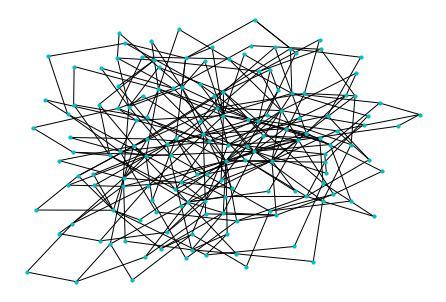

In [36]:

G_14 = nx.Graph()
G_14 = nonlinear_barabasi_albert_graph(150,2, 0.001, seed)
#G_14 = nonlinear_barabasi_albert_graph(n_, m_, alpha_, seed)

vlbd_14,mvr_14,lambda_c_14 = calculando_sincronizacao(G_14)
#lambda_c.append([lambda_c_14,'BA_NL',14])
imagem_rede(G_14)

vlbd_14


In [18]:
vlbd_14

array([], dtype=float64)

Variando o o parametro p da rede small word

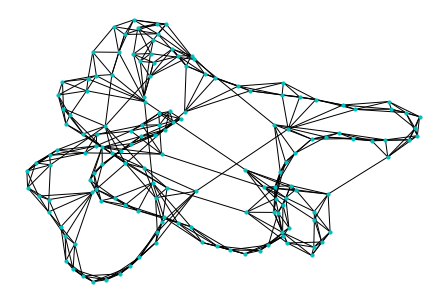

In [206]:
G_15 = nx.Graph()
G_15 = rede_small_word(N, kappa, p, seed)
vlbd_15,mvr_15,lambda_c_15 = calculando_sincronizacao(G_15)
#lambda_c.append([lambda_c_15,'SW',3])
imagem_rede(G_15)

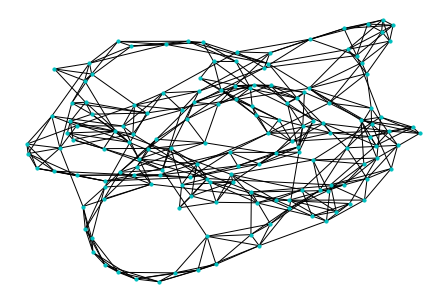

In [207]:
G_16 = nx.Graph()
G_16 = rede_small_word(N, kappa, p*2, seed)
vlbd_16,mvr_16,lambda_c_16 = calculando_sincronizacao(G_16)
#lambda_c.append([lambda_c_16,'SW',16])
imagem_rede(G_16)

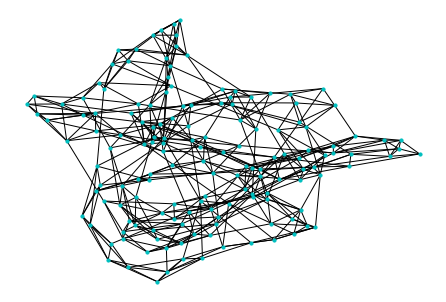

In [208]:
G_17 = nx.Graph()
G_17 = rede_small_word(N, kappa, p*3, seed)
vlbd_17,mvr_17,lambda_c_17 = calculando_sincronizacao(G_17)
#lambda_c.append([lambda_c_17,'SW',17])
imagem_rede(G_17)

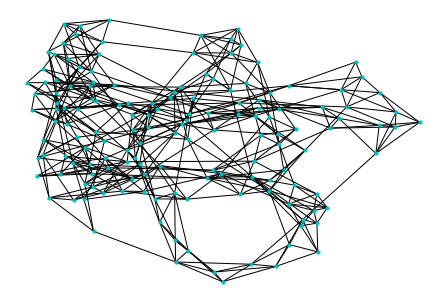

In [209]:
G_18 = nx.Graph()
G_18 = rede_small_word(N, kappa, p*4, seed)
vlbd_18,mvr_18,lambda_c_18 = calculando_sincronizacao(G_18)
#lambda_c.append([lambda_c_18,'SW',18])
imagem_rede(G_18)

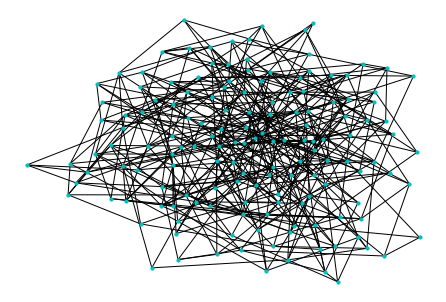

In [210]:
G_19 = nx.Graph()
G_19 = rede_small_word(N, kappa, 1, seed)
vlbd_19,mvr_19,lambda_c_19 = calculando_sincronizacao(G_19)
#lambda_c.append([lambda_c_19,'SW',19])
imagem_rede(G_19)

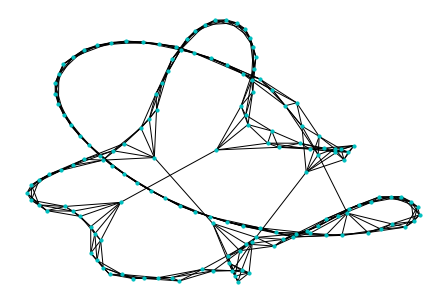

In [213]:
G_20 = nx.Graph()
G_20 = rede_small_word(N, kappa, p/10, seed)
vlbd_20,mvr_20,lambda_c_20 = calculando_sincronizacao(G_20)
#lambda_c.append([lambda_c_20,'SW',20])
imagem_rede(G_20)

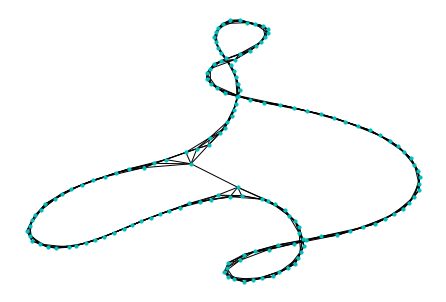

In [ ]:
G_21 = nx.Graph()
G_21 = rede_small_word(N, kappa, 0.001, seed)
imagem_rede(G_21)
vlbd_21,mvr_21,lambda_c_21 = calculando_sincronizacao(G_21)
#lambda_c.append([lambda_c_20,'SW',20])


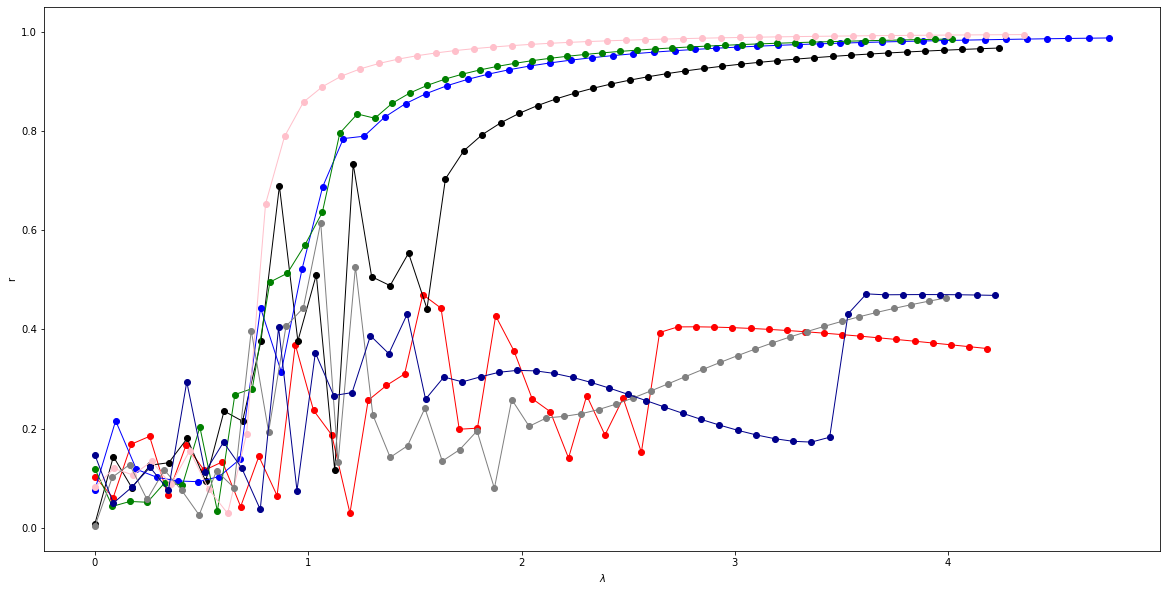

In [225]:
plt.figure(figsize=(20,10))


plt.plot(vlbd_15, mvr_15, '-o', color='red', linewidth=1 ) #  p = 0.04
plt.plot(vlbd_16, mvr_16, '-o', color='black', linewidth=1 ) # p = 0.08
plt.plot(vlbd_17, mvr_17, '-o', color='blue', linewidth=1 ) # p = 0.12
plt.plot(vlbd_18, mvr_18, '-o', color='green', linewidth=1 ) # p = 0.16
plt.plot(vlbd_19, mvr_19, '-o', color='pink', linewidth=1 ) # p = 1
plt.plot(vlbd_20, mvr_20, '-o', color='gray', linewidth=1 ) # p = 0.004
plt.plot(vlbd_21, mvr_21, '-o', color='darkblue', linewidth=1 ) # p = 0.001



#plt.axvline(x =lambda_c_8)
xlabel(r"$\lambda$")
ylabel("r")
#plt.legend(True)
plt.plot(True)

Heat Map

In [348]:
import seaborn as sns
import pandas as pd

df = []

df = pd.DataFrame({'acoplamento':vlbd_6,'tempo':mvr_6,'mu':0.05})
df = df.append(pd.DataFrame({'acoplamento':vlbd_8,'tempo':mvr_8,'mu':0.1}))
df = df.append(pd.DataFrame({'acoplamento':vlbd_9,'tempo':mvr_9,'mu':0.15}))
df = df.append(pd.DataFrame({'acoplamento':vlbd_10,'tempo':mv_10,'mu':0.2}))
df = df.append(pd.DataFrame({'acoplamento':vlbd_11,'tempo':mvr_11,'mu':0.25}))
df = df.append(pd.DataFrame({'acoplamento':vlbd_12,'tempo':mvr_12,'mu':0.3}))
df = df.append(pd.DataFrame({'acoplamento':vlbd_13,'tempo':mvr_13,'mu':0.35}))


df['tempo'] = df['tempo'].round(5)


df = df.groupby(['mu','tempo'])['acoplamento'].mean().reset_index()
df['tempo'] = df['tempo'].interpolate()
df_pivot = df.pivot(index='tempo', columns='mu',values='acoplamento')
df_pivot=df_pivot.fillna(method='ffill', axis=0)
df_pivot=df_pivot.fillna(0)

df = df.groupby(['mu','tempo'])['acoplamento'].mean().reset_index()
df['tempo'] = df['tempo'].interpolate()
df_pivot = df.pivot(index='tempo', columns='mu',values='acoplamento')

df_pivot=df_pivot.fillna(method='ffill', axis=0)
df_pivot=df_pivot.fillna(0)


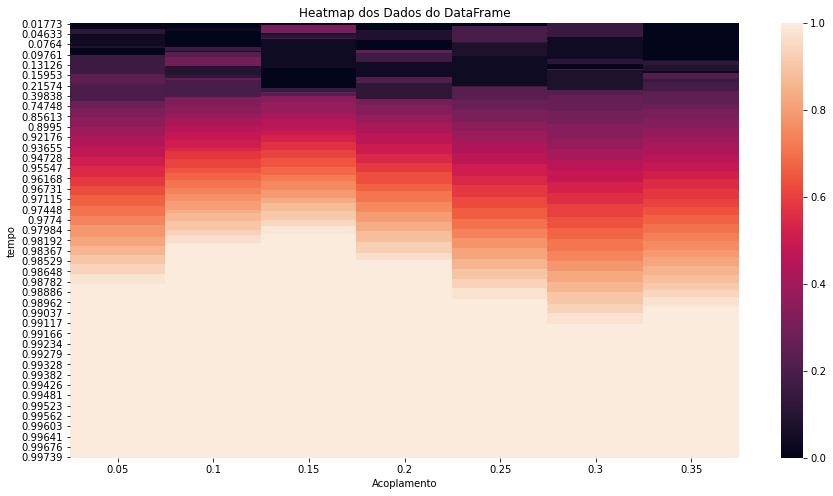

In [350]:
# Criação do heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot, annot=False,vmin=0,vmax=1)

# Adicionando títulos e rótulos
plt.title('Heatmap dos Dados do DataFrame')
plt.xlabel('Acoplamento')
#plt.ylabel('Índice')

# Mostrando o gráfico
plt.show()